In [ ]:
import $ivy.`org.proml::proml-core:0.1.0`
import $ivy.`org.proml::proml-breeze-backend:0.1.0`
import $ivy.`com.cibo::evilplot-jupyter-scala:0.6.1-SNAPSHOT`
import $ivy.`com.cibo::evilplot-repl:0.6.1-SNAPSHOT`

import proml._
import proml.distributions.Continuous._
import proml.samplers.MetropolisHastings
import proml.distributions.Continuous._
import proml.backend.MatrixOps, MatrixOps.Matrix
import proml.backend.Breeze, Breeze._
import proml.samplers.MetropolisHastings

import com.cibo.evilplot._
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.numeric.{Point, Point3d}
import com.cibo.evilplot.displayPlot
import com.cibo.evilplot.plot.ScatterPlot
import com.cibo.evilplot.colors.{ContinuousColoring, HTMLNamedColors}
import com.cibo.evilplot.demo.DemoPlots.plotAreaSize
import com.cibo.evilplot.plot.renderers.{PointRenderer, SurfaceRenderer}

import almond.interpreter.api._
import almond.api.helpers.Display.Image

import com.cibo.evilplot.geometry.Drawable
import scala.util.Random
import breeze.linalg.DenseMatrix

import scala.util.Random


def makeMoons: (Seq[(Double, Double)], Seq[(Double, Double)]) = {
    def noise = Random.nextDouble() / 2d
    val points1 = (-Math.PI to Math.PI by 0.01d).map { i =>
      (-Math.PI / 4 + Math.cos(i) + noise, Math.abs(Math.sin(i)) + noise)
    }
    val points2 = (-Math.PI to Math.PI by 0.01d).map { i =>
      (-Math.PI / 4 + 1 - Math.cos(i) + noise, -1 * Math.abs(Math.sin(i)) + noise)
    }
    (points1, points2)
}
    
def show(drawable: Drawable) {
    import java.io.ByteArrayOutputStream
    import javax.imageio.ImageIO
    val baos = new ByteArrayOutputStream()
    ImageIO.write(drawable.asBufferedImage, "png", baos)
    try{Image.fromArray(baos.toByteArray(), Image.PNG)}
    catch{
      case e: Exception =>  
    }
}  

def scatterPlot(points: Seq[Point3d[Double]]) = {
    val plot = ScatterPlot(
      points,
      pointRenderer = Some(PointRenderer.depthColor[Point3d[Double]](
        x => x.z,
        points.map(_.z).min,
        points.map(_.z).max,
        Some(ContinuousColoring
          .gradient3(HTMLNamedColors.green, HTMLNamedColors.yellow, HTMLNamedColors.red)),
        None
      ))
    ).standard()
      .xLabel("x")
      .yLabel("y")
      .rightLegend()
      .render(plotAreaSize)
    show(plot)
}


class _N
class _2
class _5
class _1

val (points1, points2) = makeMoons
val input              = Matrix[DM, _N, _2](DenseMatrix(points1 ++ points2: _*))
val output = Matrix[DM, _N, _1](DenseMatrix(Seq.fill(points1.size)(0.0) ++ Seq.fill(points2.size)(1.0): _*))


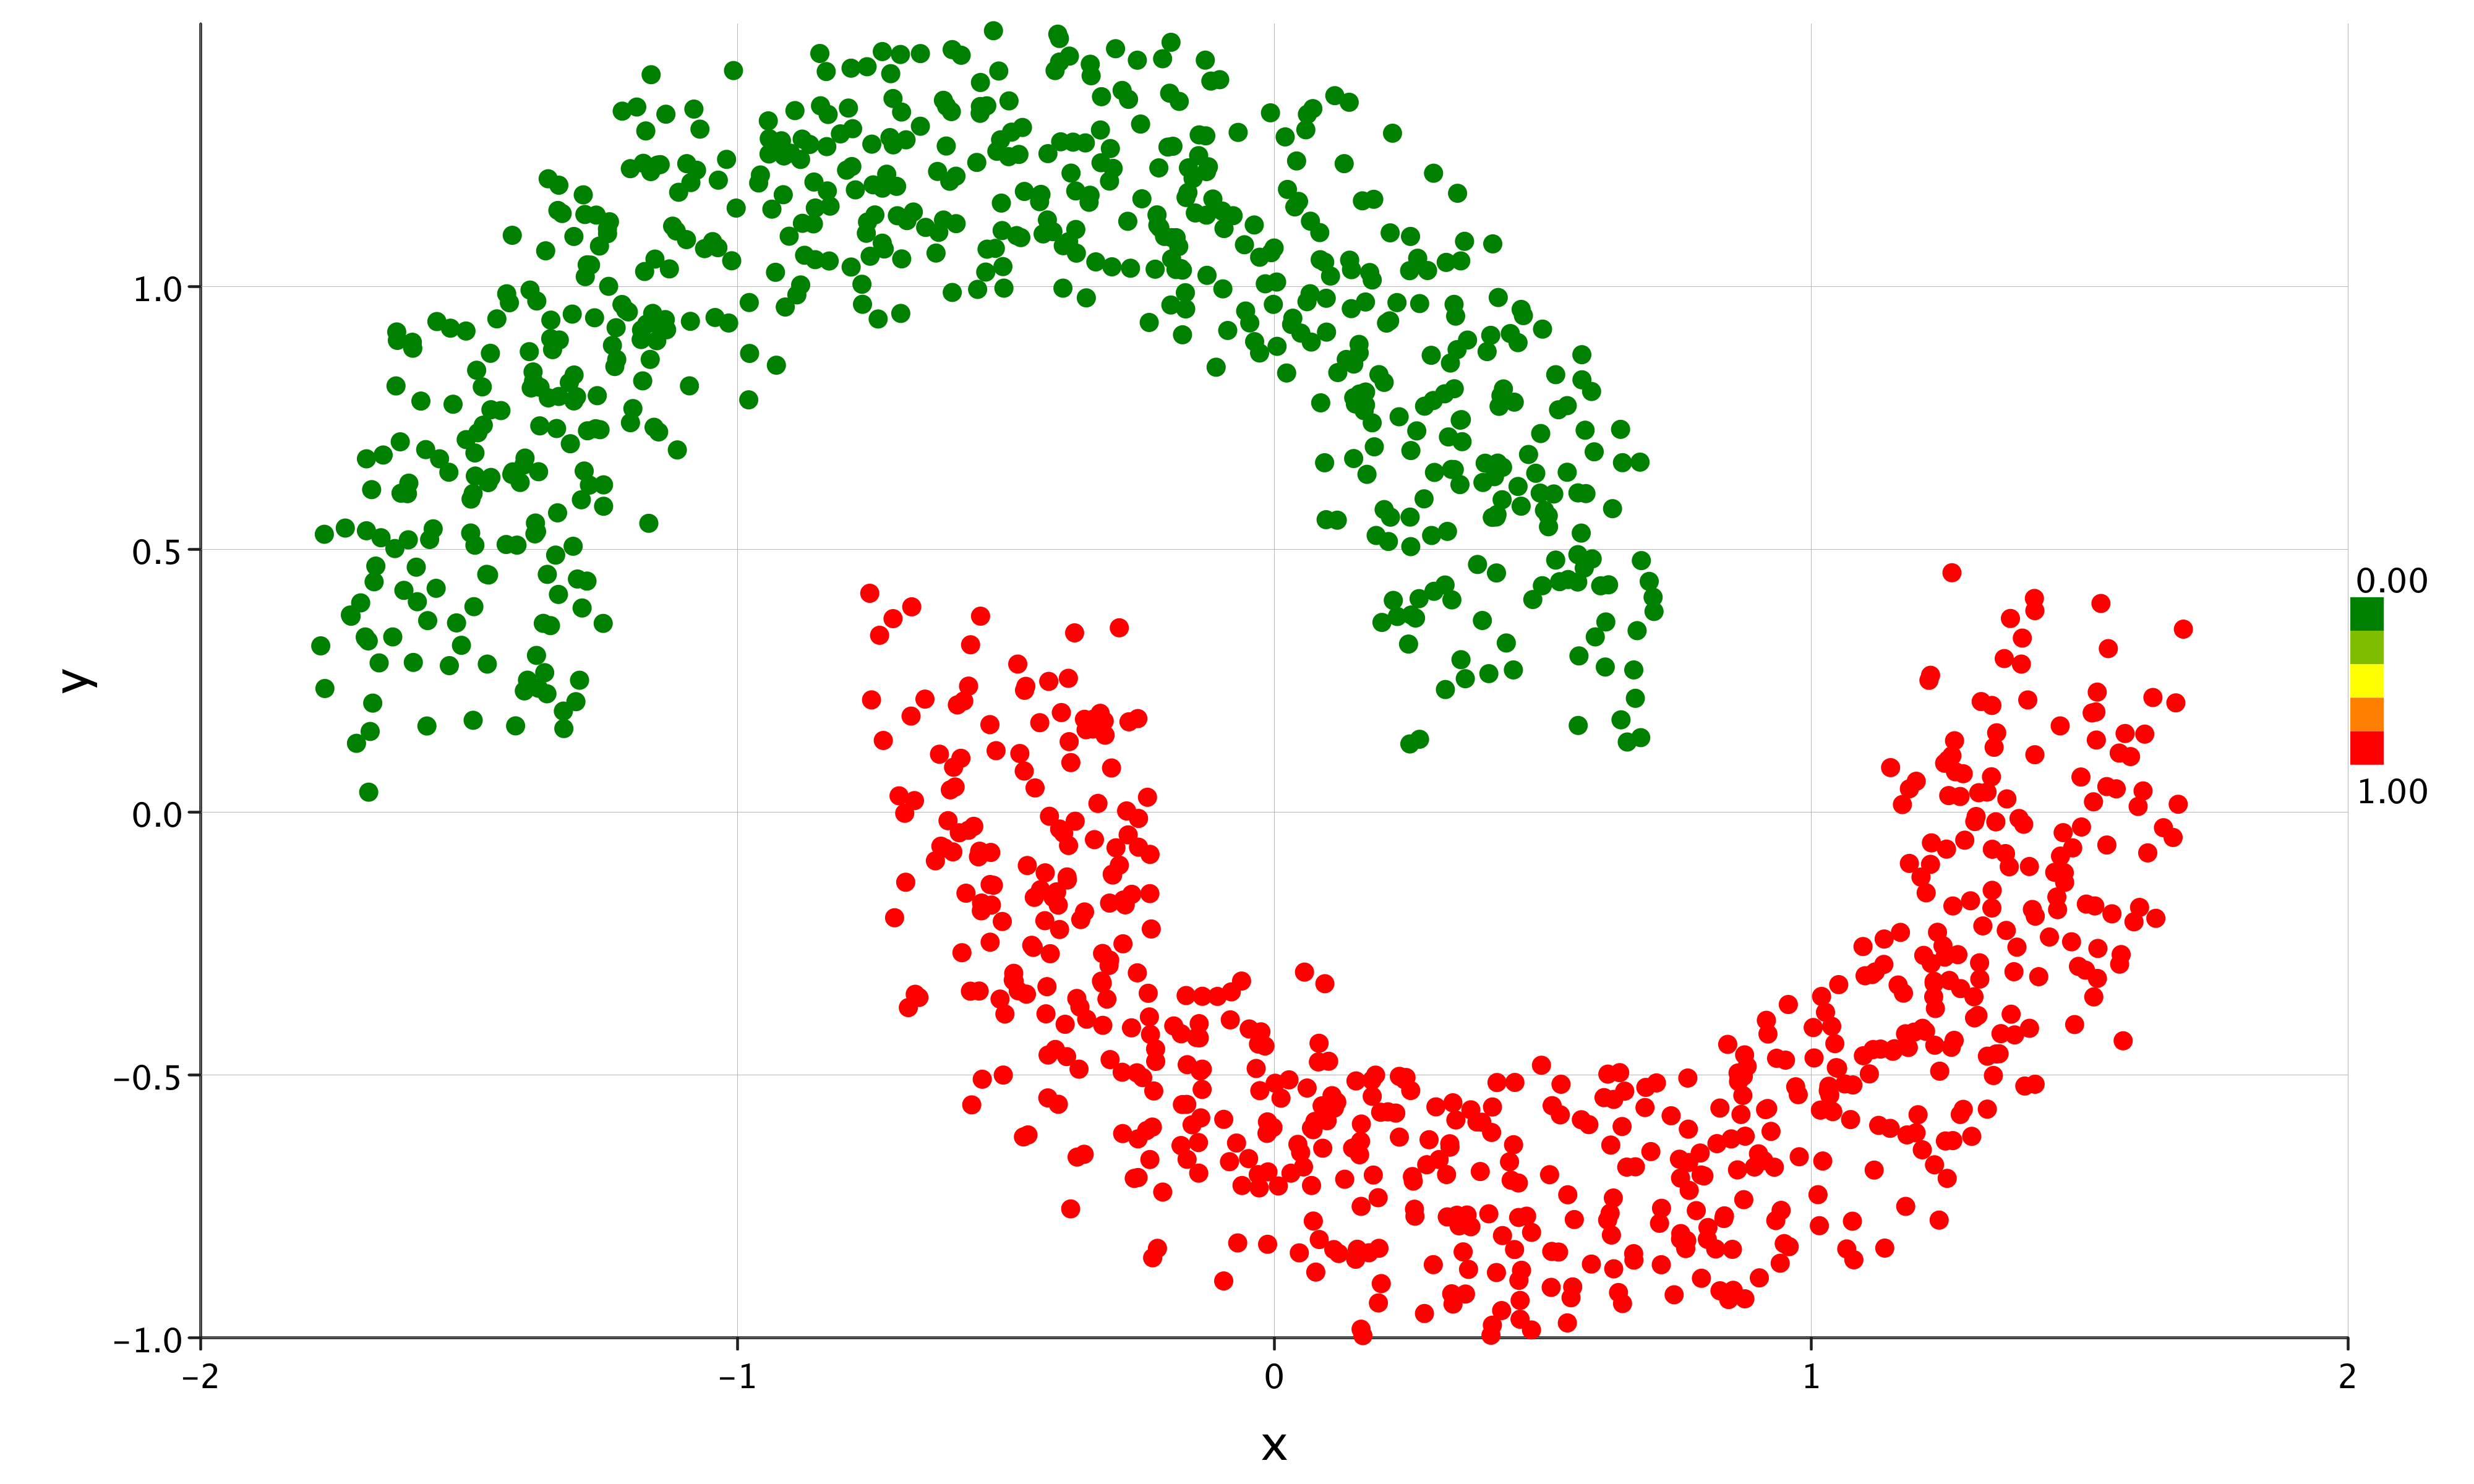

In [2]:
scatterPlot(
(points1 ++ points2).zip(Seq.fill(points1.size)(0.0) ++ Seq.fill(points2.size)(1.0)).map {
  case ((x, y), z) => Point3d[Double](x, y, z)
})

In [ ]:
case class Params(w1: Matrix[DM, _2, _5], w2: Matrix[DM, _5, _5], w3: Matrix[DM, _5, _1])

val ones = Params(
  Matrix[DM, _2, _5](DM1(2, 5)),
  Matrix[DM, _5, _5](DM1(5, 5)),
  Matrix[DM, _5, _1](DM1(5, 1)),
)
val zeros = Params(
  Matrix[DM, _2, _5](DM0(2, 5)),
  Matrix[DM, _5, _5](DM0(5, 5)),
  Matrix[DM, _5, _1](DM0(5, 1)),
)
val priorAssumption = zeros

def getLogPrior(p: Params): Double = {
  import priorAssumption._
  normal[Matrix[DM, _2, _5]](w1, ones.w1).logPdf(p.w1) +
  normal[Matrix[DM, _5, _5]](w2, ones.w2).logPdf(p.w2) +
  normal[Matrix[DM, _5, _1]](w3, ones.w3).logPdf(p.w3)
}

def getProposal(prior: Params) =
  for {
    rn1 <- normal[Matrix[DM, _2, _5]](prior.w1, ones.w1)
    rn2 <- normal[Matrix[DM, _5, _5]](prior.w2, ones.w2)
    rn3 <- normal[Matrix[DM, _5, _1]](prior.w3, ones.w3)
  } yield Params(rn1, rn2, rn3)

val neuralNetwork = new Model[Params, Matrix[DM, _N, _2], Matrix[DM, _N, _1]] {
  override def proposal = (p: Params) => getProposal(p).get
  override def logPrior = getLogPrior
  override def model =
    (p: Params) =>
      (x: Matrix[DM, _N, _2]) => {
        import p._
        import breezeInstance._
        msigmoid(mtanh(mtanh(x dotProduct w1) dotProduct w2) dotProduct w3)
    }
  override def prior = priorAssumption
}

val (best, samples) = neuralNetwork.fit(Seq((input, output)), MetropolisHastings(20000, 15000))

val r = BigDecimal(-5).until(5, 0.1)
val points = for {
  x <- r
  y <- r
} yield {
  (x.toDouble, y.toDouble)
}

def predictions(model: Params) = {
  import breezeInstance._
  val testInput: Matrix[DM, _N, _2] = Matrix[DM, _N, _2](DenseMatrix(points: _*))
  msigmoid(mtanh(mtanh(testInput dotProduct model.w1) dotProduct model.w2) dotProduct model.w3).underlying.toDenseVector.toArray
}

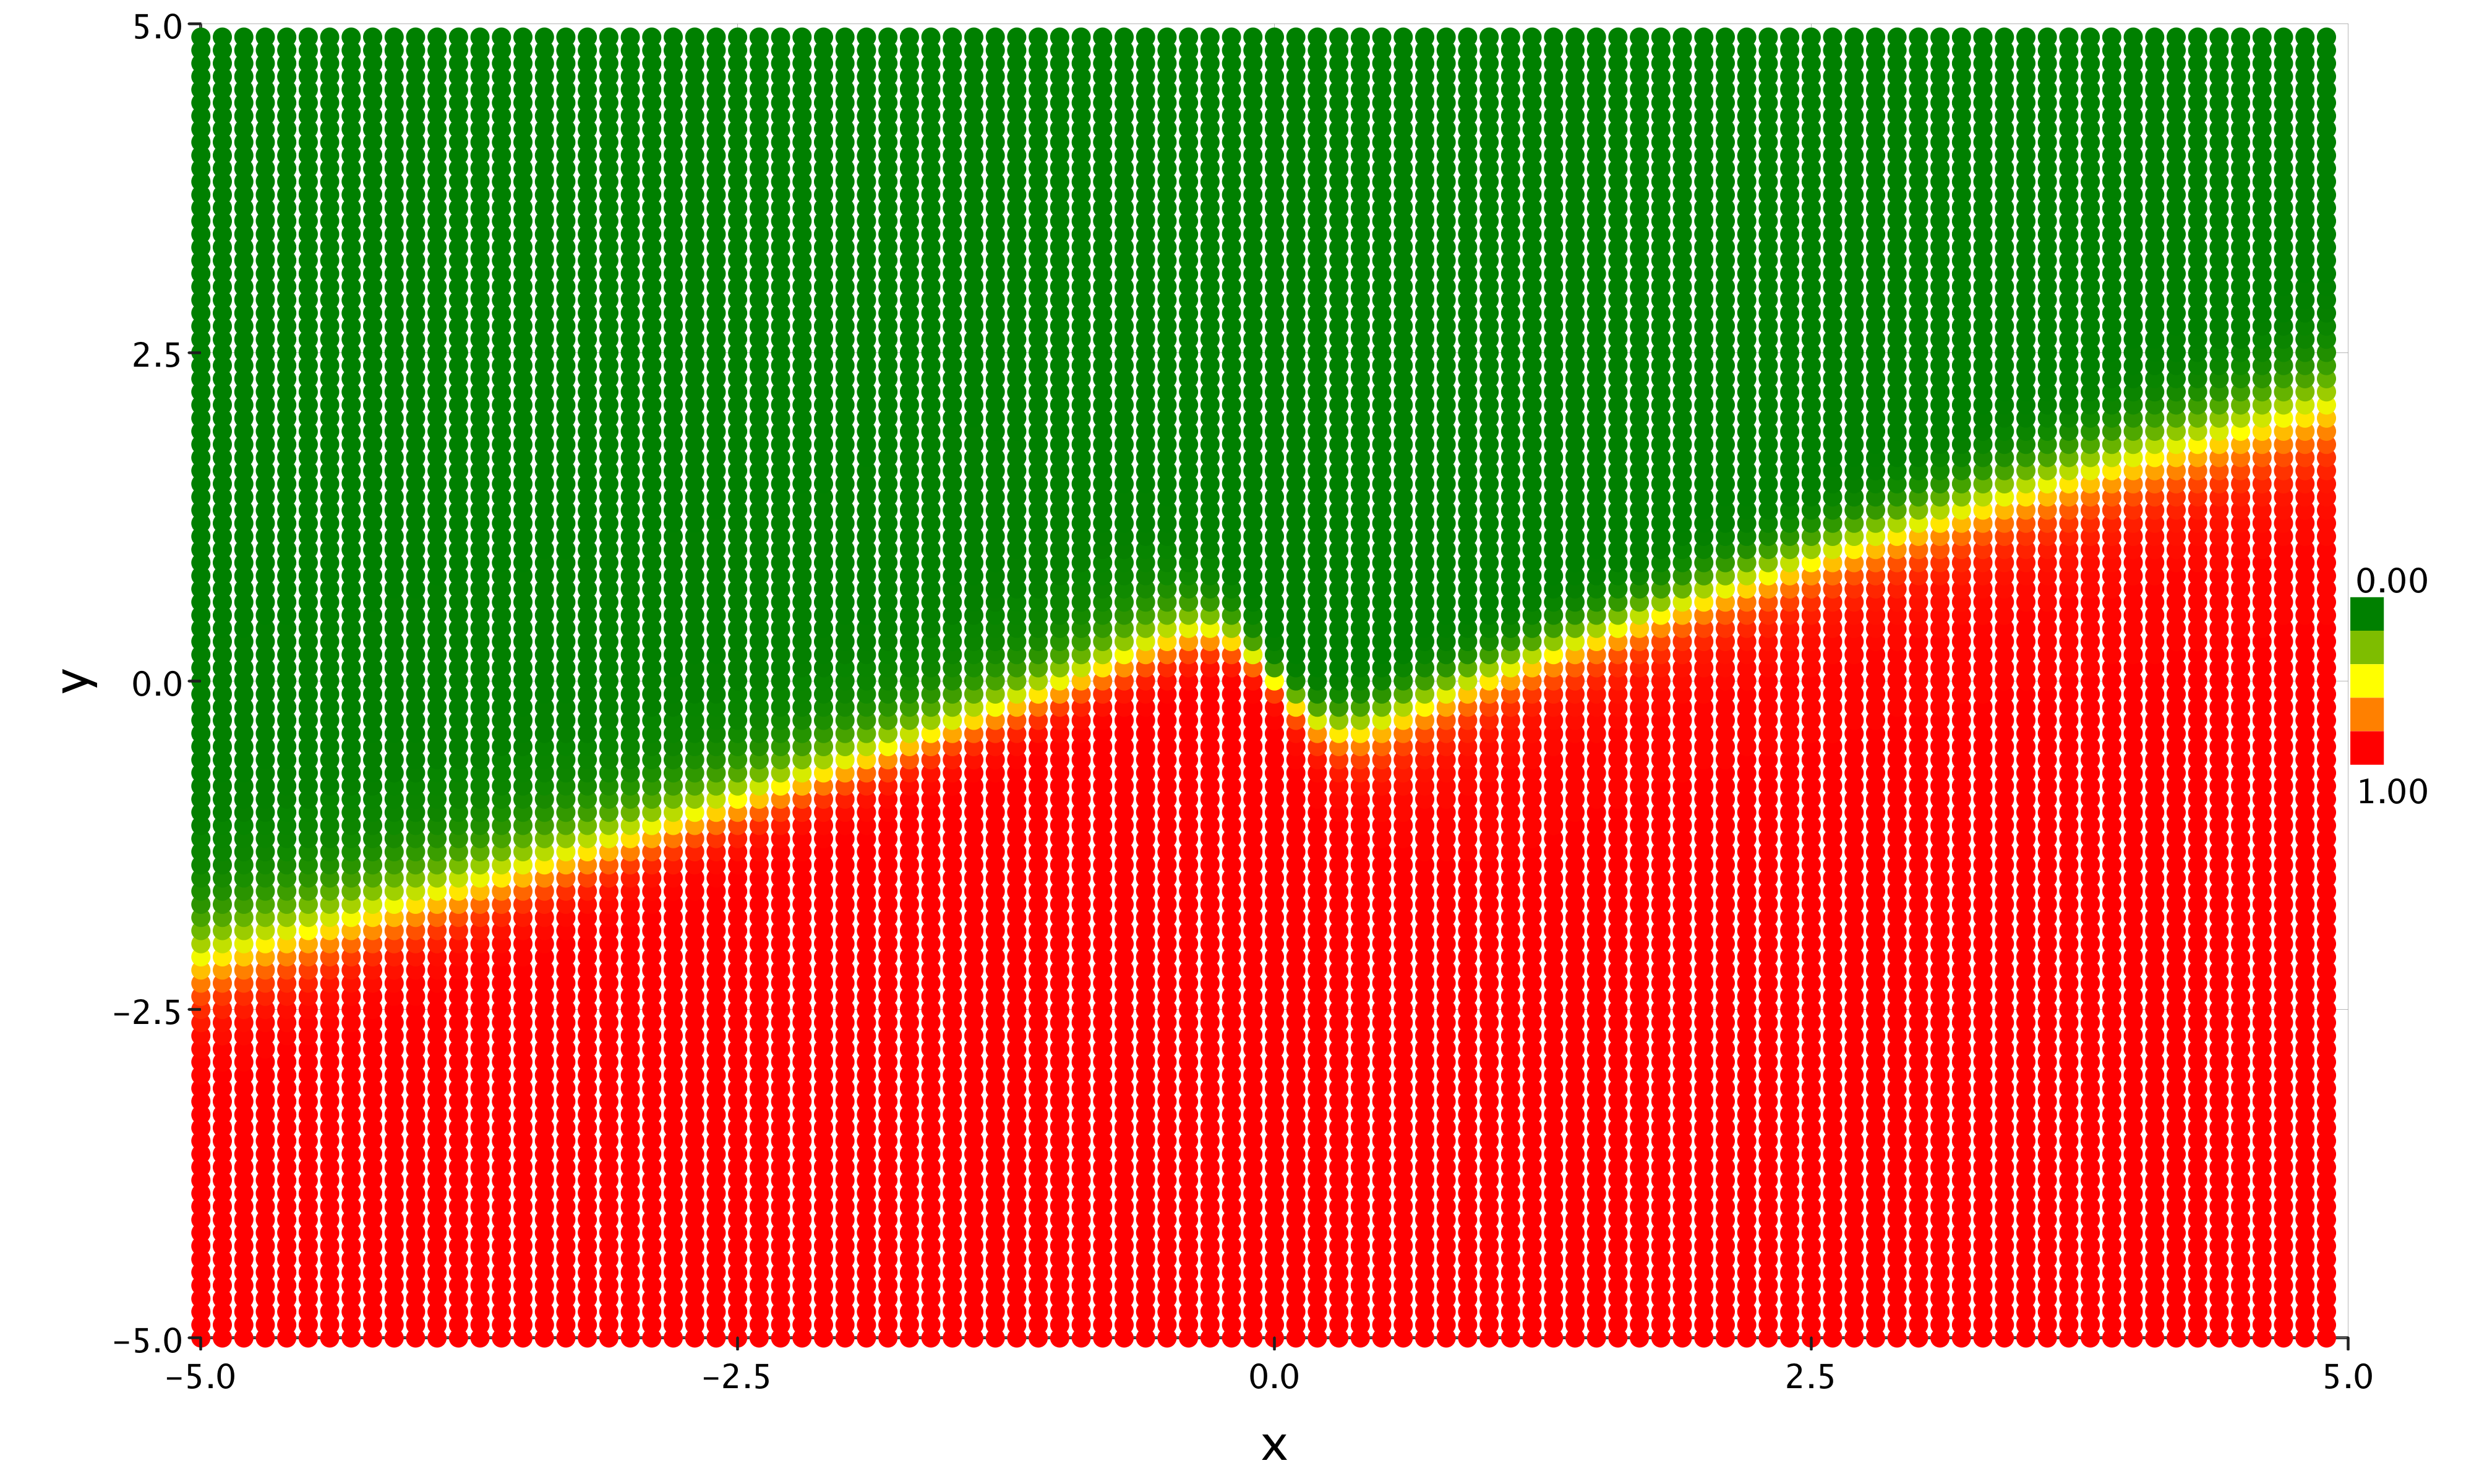

In [21]:
scatterPlot(points.zip(predictions(best)).map { case ((x, y), z) => Point3d[Double](x, y, z) })

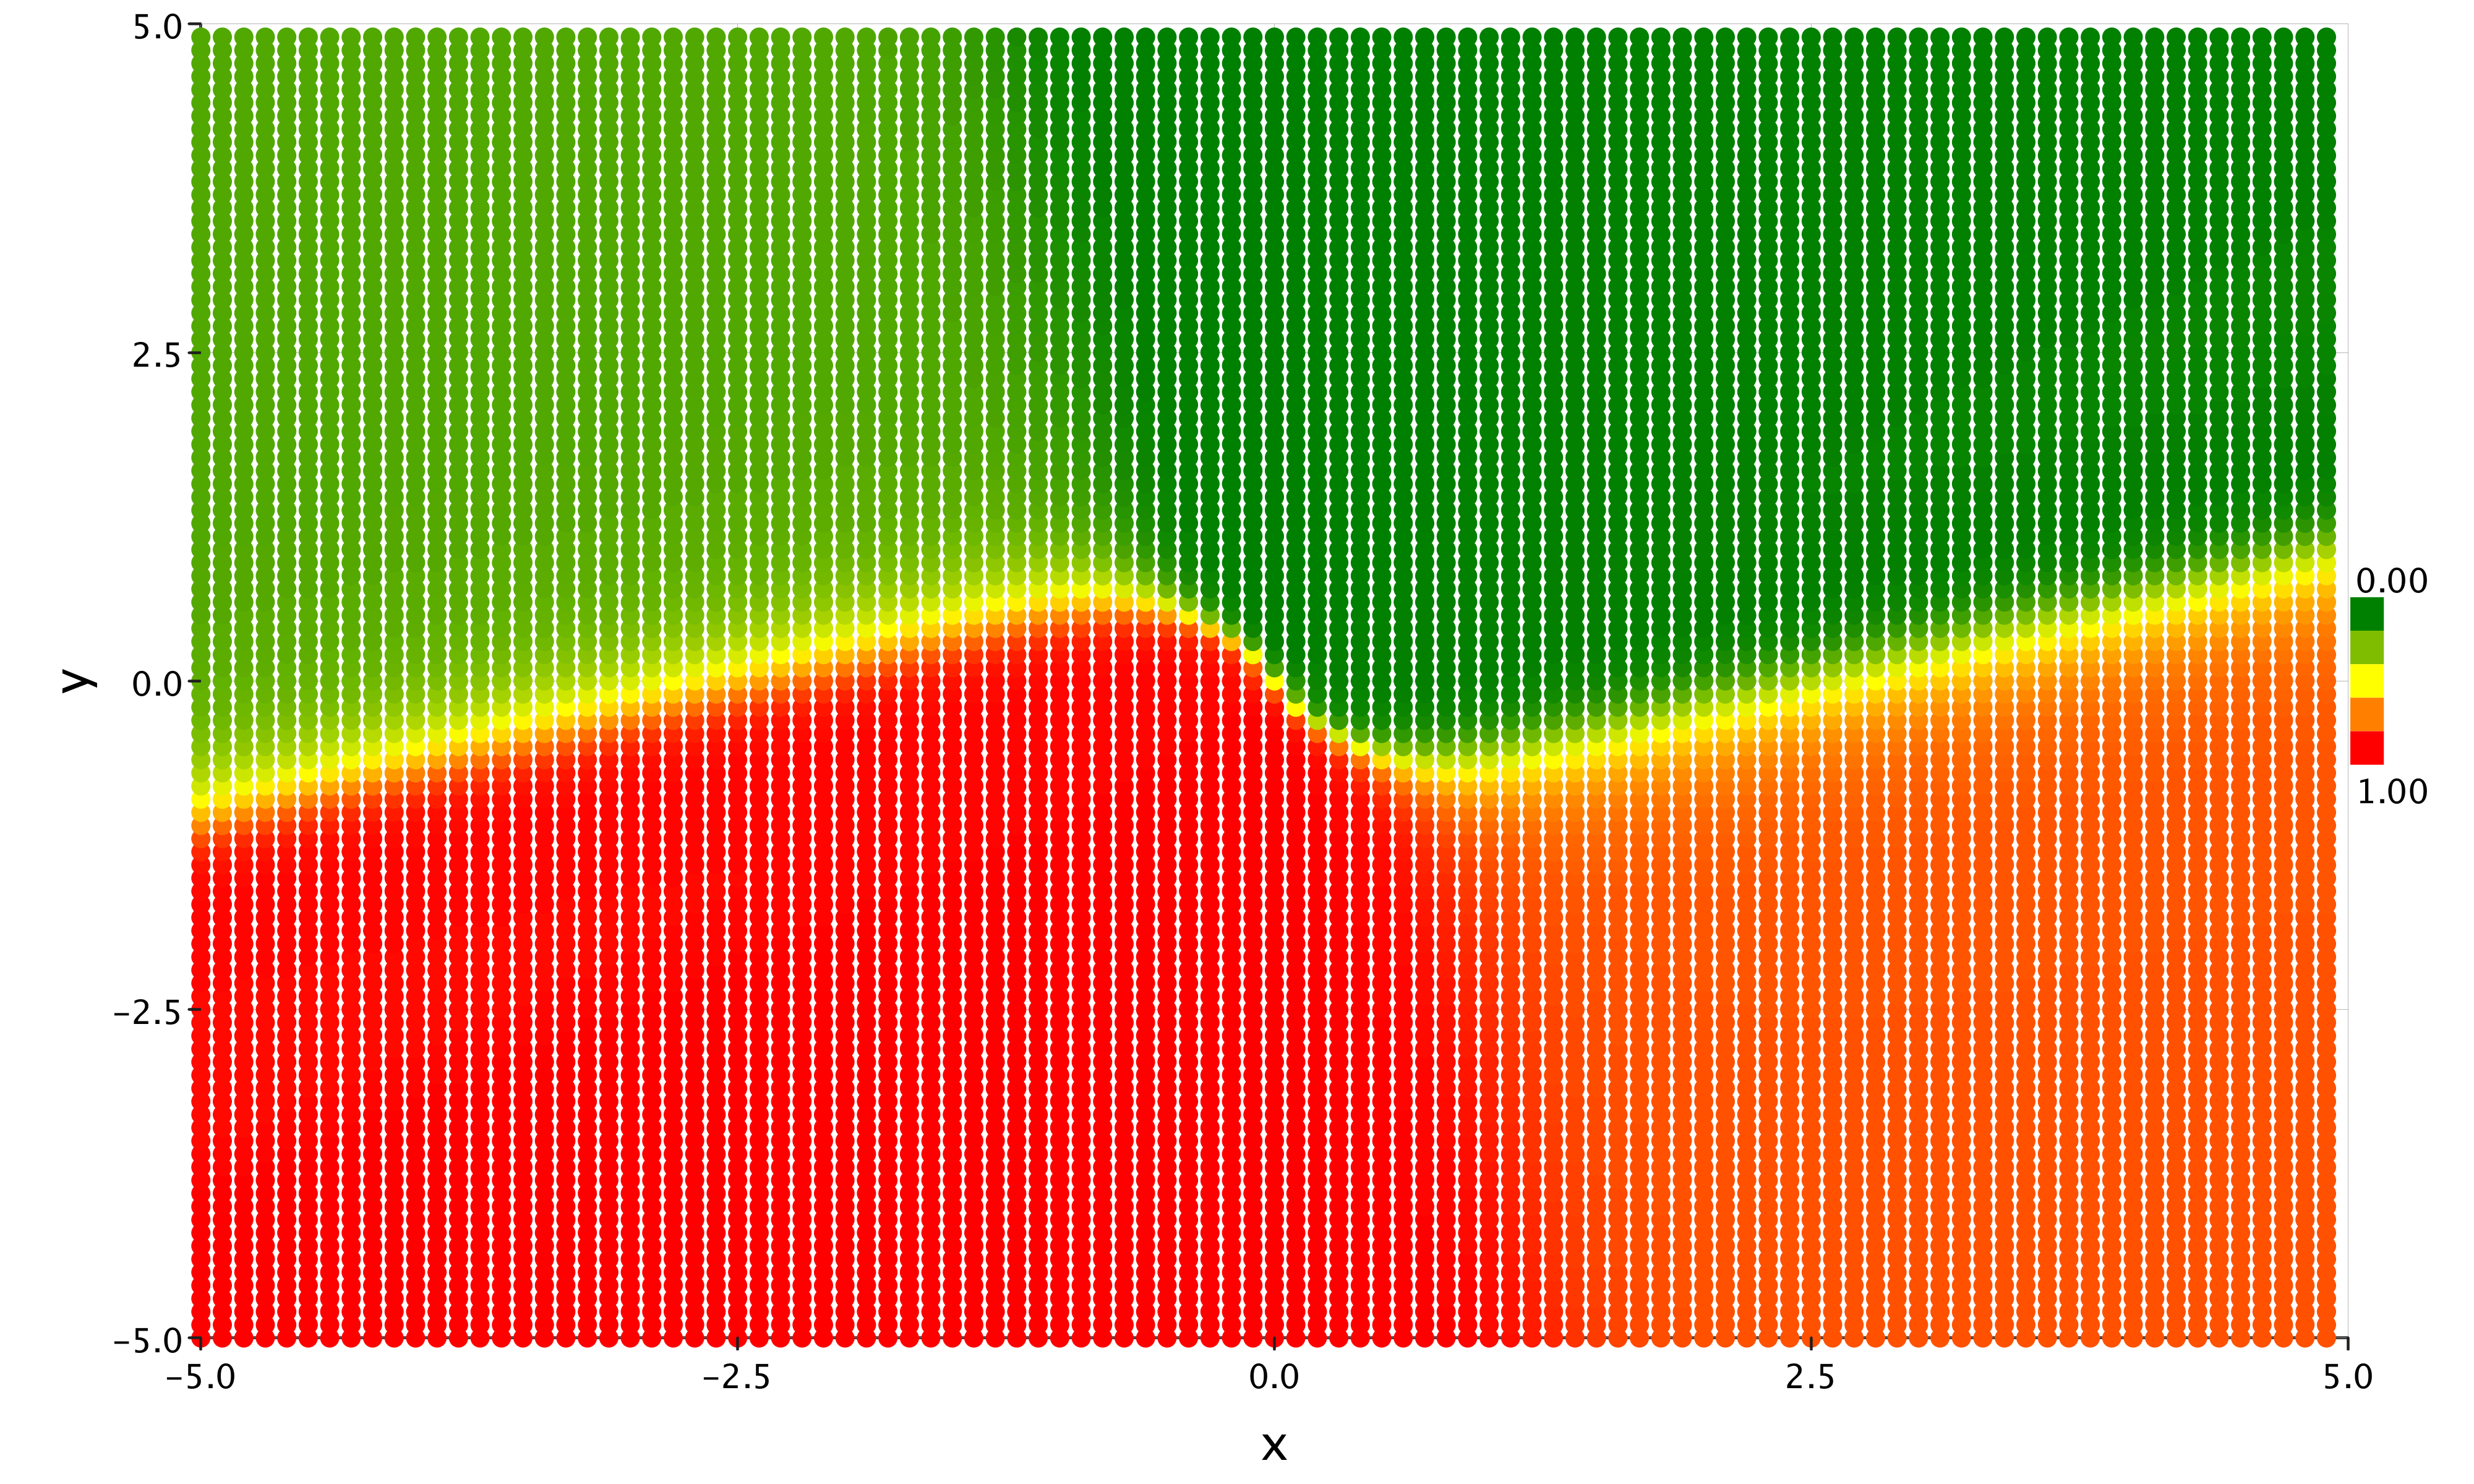

In [18]:
scatterPlot(points.zip(predictions(samples(4300))).map { case ((x, y), z) => Point3d[Double](x, y, z) })